# Diversity

For this experiment, we will want to find multiple different levels with the same difficulty.

In [18]:
import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU, functional as F
from torch.optim import Adam

from framework import SeededGenerator
from pendulum import PendulumEnvironment
from pendulum.heuristic import HeuristicPendulumEvaluator
from shared_parameters import *
from utils import running_average

torch.set_printoptions(linewidth=120, sci_mode=False)

Here our generator NN will define the *offset* from the point in space, that is
also fed in as an input to the generator.

Preview of the embedding space and difficulties

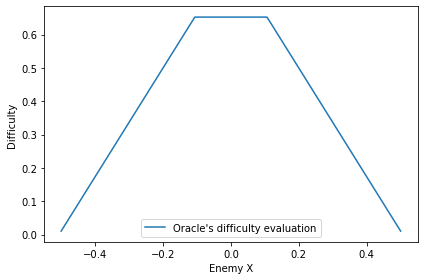

In [2]:
env = PendulumEnvironment(*pendulum_env_args)
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
states = torch.stack([state.clone() for _ in range(100)])
enemy_xs = torch.linspace(enemy_x_min, enemy_x_max, states.shape[0]).unsqueeze(-1)
states.enemy_x = enemy_xs
evaluation = oracle(states.enemy_x)

axs = plt.subplot()

axs.plot(enemy_xs, evaluation)
axs.set_xlabel("Enemy X")
axs.set_ylabel("Difficulty")
axs.legend(["Oracle's difficulty evaluation"])
plt.tight_layout()

plt.show()

We see that for the same difficulty, there exist several levels, that have the same difficulty.
However, with the way we've set up our generators, they can only output a single level for the given difficulty.

Now let's give the generator two inputs: the input difficulty $d_{in}$, as well the seed $\epsilon$

    Let's try with the simultaneous learning first

It.: 512, difficulty_loss=0.12595 offsets_loss=0.12901


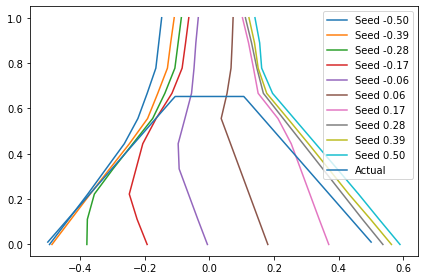

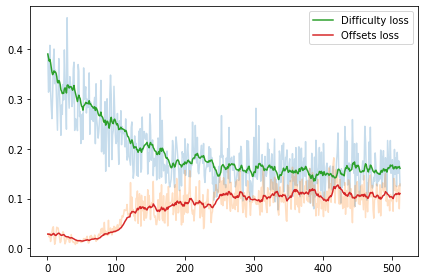

In [28]:
%matplotlib inline

oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

bounds = torch.tensor([[enemy_x_min, enemy_x_max]])
generator = SeededGenerator(bounds, hidden=[8, 8], activation=LeakyReLU(), optimizer_class=Adam, lr=0.01,
                            loss_function=F.l1_loss)
num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(enemy_x_min, enemy_x_max, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)

iteration = 0
loss_evaluator = float("inf")

state = env.get_starting_state()

losses_difficulty = []
losses_offsets = []
iterations = []

def iterate(verbose=False):
    global dataset, iteration

    # Sample from the dataset
    indices = torch.randperm(dataset.shape[0])[:15]
    sample = dataset[indices]

    # Generate levels
    generated_levels = generator(sample)

    # Estimate the difficulty
    d_out = oracle(generated_levels)

    # Train the generator on the evaluated difficulty
    loss_difficulty, loss_offsets = generator.update(d_out)

    iteration += 1

    iterations.append(iteration)
    losses_difficulty.append(loss_difficulty.item())
    losses_offsets.append(loss_offsets.item())

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"difficulty_loss={loss_difficulty.item():.5f} "
              f"offsets_loss={loss_offsets.item():.5f}")

        # print("Parameters:")
        # for p in generator.parameters():
        #     print(p.data)

        r_difficulties = torch.linspace(0, 1, 10)
        r_seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
        r_dataset = torch.cartesian_prod(r_difficulties, r_seeds)

        generated_states = generator(r_dataset).detach()

        r_states = torch.stack([state.clone() for _ in range(generated_states.shape[0])])
        for i in range(10):
            r_states[i * 10:(i+1) * 10].enemy_x = r_seeds.unsqueeze(-1)

        d_out = oracle(r_states.enemy_x)

        collected = torch.hstack((r_dataset, generated_states, d_out))

        _, ax = plt.subplots()

        for i in range(r_seeds.shape[0]):
            selected = collected[i::r_difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            ax.plot(xs, ds)

        ax.plot(enemy_xs, evaluation)

        ax.legend([*[f"Seed {seed:.2f}" for seed in r_seeds], "Actual"])
        plt.tight_layout()

        plt.show()

        _, ax = plt.subplots()
        ax.plot(iterations, losses_difficulty, alpha=0.25)
        ax.plot(iterations, losses_offsets, alpha=0.25)
        ax.plot(iterations, running_average(losses_difficulty, 0.9), label="Difficulty loss")
        ax.plot(iterations, running_average(losses_offsets, 0.9), label="Offsets loss")
        ax.legend()
        plt.tight_layout()

        plt.show()


iterate()

try:
    for _ in range(10):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

It.: 2045, difficulty_loss=0.08125 offsets_loss=0.12179


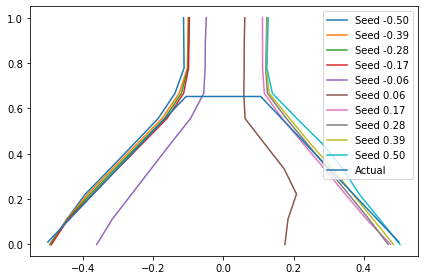

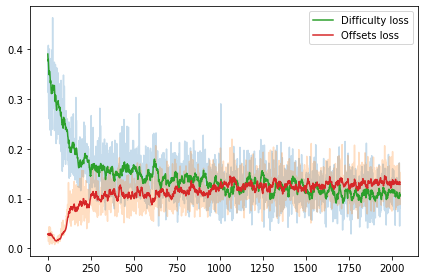

In [31]:
try:
    for _ in range(10):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

In [32]:
%matplotlib qt

iterate(True)

It.: 2046, difficulty_loss=0.11877 offsets_loss=0.17140
